In [1]:
!pip install disarray

In [2]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools
import disarray

In [3]:
def count_jpg_files(root_dir):
    """
    Count all .jpg files in the given directory and its subdirectories
    
    Args:
        root_dir (str): Path to the root directory to start searching from
        
    Returns:
        int: total count
    """
    total_count = 0
    dir_counts = {}
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count jpg files in current directory
        jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
        total_count += jpg_count
    
    return total_count

In [4]:
train_path = '/kaggle/input/multiclassunetsegmentedimages/unet_segmented/train_directory'
validation_path = '/kaggle/input/multiclassunetsegmentedimages/unet_segmented/validation_directory'
test_path = '/kaggle/input/multiclassunetsegmentedimages/unet_segmented/test_directory'

In [5]:
preprocess_input = tensorflow.keras.applications.mobilenet_v2.preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(validation_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

test_image_gen = image_gen.flow_from_directory(test_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

print(test_image_gen.class_indices)

Found 36927 images belonging to 7 classes.
Found 883 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [7]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))
    return f1_score_value

In [10]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy, precision, recall, f1_score])

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.5,
    patience=3,        
    mode='max',
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,       
    mode='min',
    restore_best_weights=True,
    verbose=1
)

model_chkpt = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [12]:
total_samples = sum([5115, 5950, 5990, 5462, 5510, 4810, 4090])
class_weights = {
    0: total_samples / 5510,
    1: total_samples / 5462,
    2: total_samples / 5990,
    3: total_samples / 4090,
    4: total_samples / 5950,
    5: total_samples / 5115,
    6: total_samples / 4810
}

In [13]:
history = tl_model.fit(train_image_gen,
                       epochs=30, 
                       validation_data = val_image_gen,
                       class_weight=class_weights,
                       callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - categorical_accuracy: 0.5057 - f1_score: 0.4242 - loss: 11.2181 - precision: 0.6711 - recall: 0.3282 - top_2_accuracy: 0.7014 - top_3_accuracy: 0.8177
Epoch 1: val_categorical_accuracy improved from -inf to 0.67497, saving model to best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 257s 357ms/step - categorical_accuracy: 0.5059 - f1_score: 0.4244 - loss: 11.2147 - precision: 0.6712 - recall: 0.3284 - top_2_accuracy: 0.7015 - top_3_accuracy: 0.8178 - val_categorical_accuracy: 0.6750 - val_f1_score: 0.6806 - val_loss: 3.3610 - val_precision: 0.7159 - val_recall: 0.6495 - val_top_2_accuracy: 0.7905 - val_top_3_accuracy: 0.8584 - learning_rate: 1.0000e-04
Epoch 2/30
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - categorical_accuracy: 0.7461 - f1_score: 0.7357 - loss: 6.5107 - precision: 0.8125 - recall: 0.6732 - top_2_accuracy: 0.9073 - top_3_accuracy: 0.9675
Epoch 2: val_categorical_accuracy improved from 0.67497 to 0.67724, saving model to best_model

In [14]:
tl_model.save('val_loss_epoch.keras')

<Axes: >

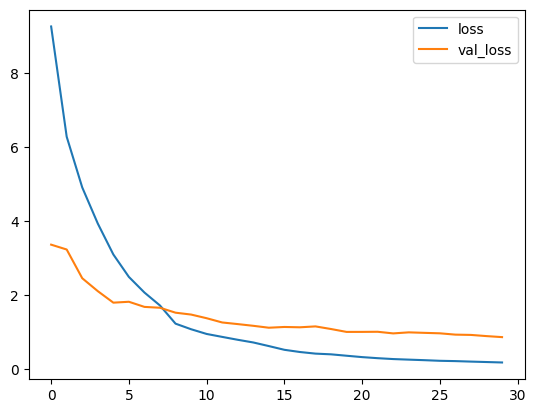

In [15]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

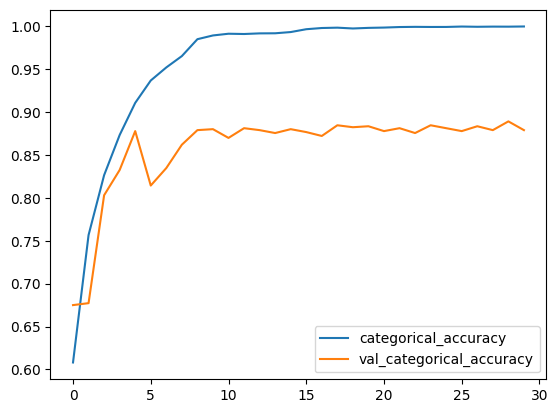

In [16]:
metrics[["categorical_accuracy","val_categorical_accuracy"]].plot()

<Figure size 640x480 with 0 Axes>

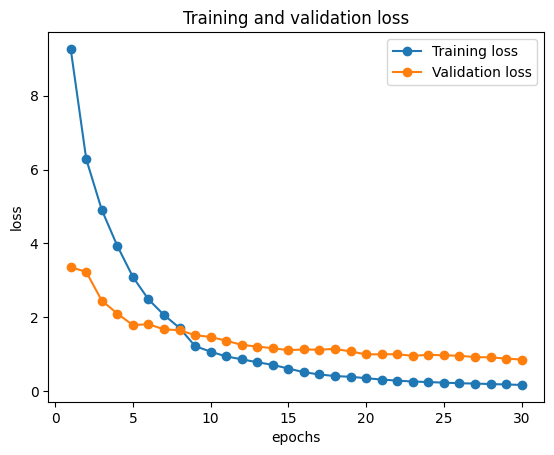

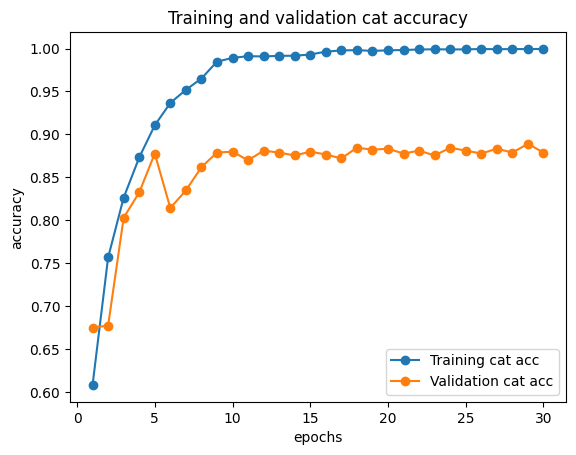

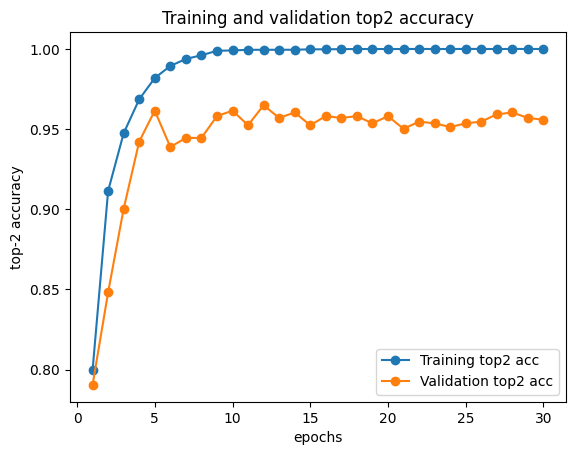

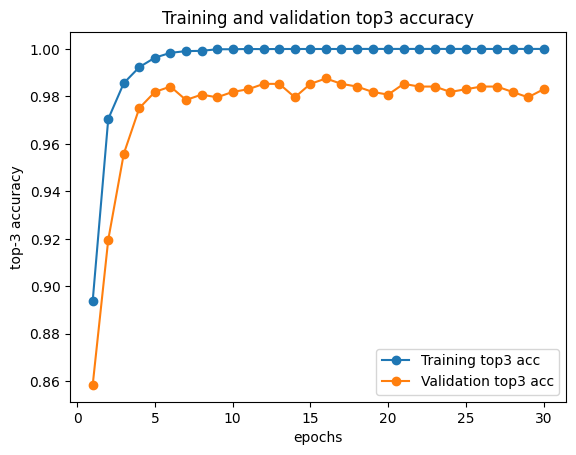

<Figure size 640x480 with 0 Axes>

In [17]:
# display the accuracy, top-2 accuracy and top-3 accuracy

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "-o", label='Training loss')
plt.plot(epochs, val_loss, "-o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.figure()
plt.savefig('loss.png', dpi=300)
plt.figure()

plt.plot(epochs, acc, "-o", label='Training cat acc')
plt.plot(epochs, val_acc, "-o", label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.figure()
plt.savefig('acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top2_acc, "-o", label='Training top2 acc')
plt.plot(epochs, val_top2_acc, "-o", label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-2 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top2acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top3_acc, "-o", label='Training top3 acc')
plt.plot(epochs, val_top3_acc, "-o", label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-3 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top3acc.png', dpi=300)
plt.figure()

In [18]:
def plot_roc_curves_from_generator(predictions, test_labels, class_names):
    """
    Plot ROC curves for predictions from a generator-based model.
    
    Parameters:
    predictions: Raw predictions from model.predict()
    test_labels: True labels from generator.classes
    class_names: List of class names in order matching generator.class_indices
    """
    # Convert predictions to probabilities if not already
    if len(predictions.shape) == 1:  # If predictions are already argmaxed
        # Convert to one-hot
        n_classes = len(class_names)
        y_pred_proba = np.zeros((len(predictions), n_classes))
        for i, pred in enumerate(predictions):
            y_pred_proba[i, pred] = 1
    else:
        y_pred_proba = predictions
    
    # Binarize the labels
    y_test_bin = label_binarize(test_labels, classes=range(len(class_names)))
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Store AUC scores
    auc_scores = {}
    
    # Plot ROC curve for each class
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[class_names[i]] = roc_auc
        
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    return plt.gcf(), auc_scores

# Best Model Based on Validation Categorical Accuracy

In [19]:
tl_model.load_weights('best_model.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [20]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - categorical_accuracy: 0.7740 - f1_score: 0.7768 - loss: 1.6614 - precision: 0.7796 - recall: 0.7742 - top_2_accuracy: 0.9029 - top_3_accuracy: 0.9491
val_loss: 0.8879865407943726
val_cat_acc: 0.889014720916748
val_top_2_acc: 0.956964910030365
val_top_3_acc: 0.9796149730682373
val_precision: 0.8923823237419128
val_recall: 0.8903405070304871
val_f1_score 0.8913477659225464


In [21]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [22]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

 1/18 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - categorical_accuracy: 0.6094 - f1_score: 0.6142 - loss: 2.1911 - precision: 0.6190 - recall: 0.6094 - top_2_accuracy: 0.7656 - top_3_accuracy: 0.8594

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - categorical_accuracy: 0.7737 - f1_score: 0.7761 - loss: 1.4487 - precision: 0.7779 - recall: 0.7742 - top_2_accuracy: 0.9004 - top_3_accuracy: 0.9438
test_loss: 0.7955754399299622
test_cat_acc: 0.8875793218612671
test_top_2_acc: 0.9519492387771606
test_top_3_acc: 0.9718948602676392
test_precision: 0.8952959775924683
test_recall: 0.8923611044883728
test_f1_score 0.8938169479370117


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step

AUC Scores per class:
akiec: 0.966
bcc: 0.991
bkl: 0.941
df: 0.969
mel: 0.930
nv: 0.971
vasc: 1.000


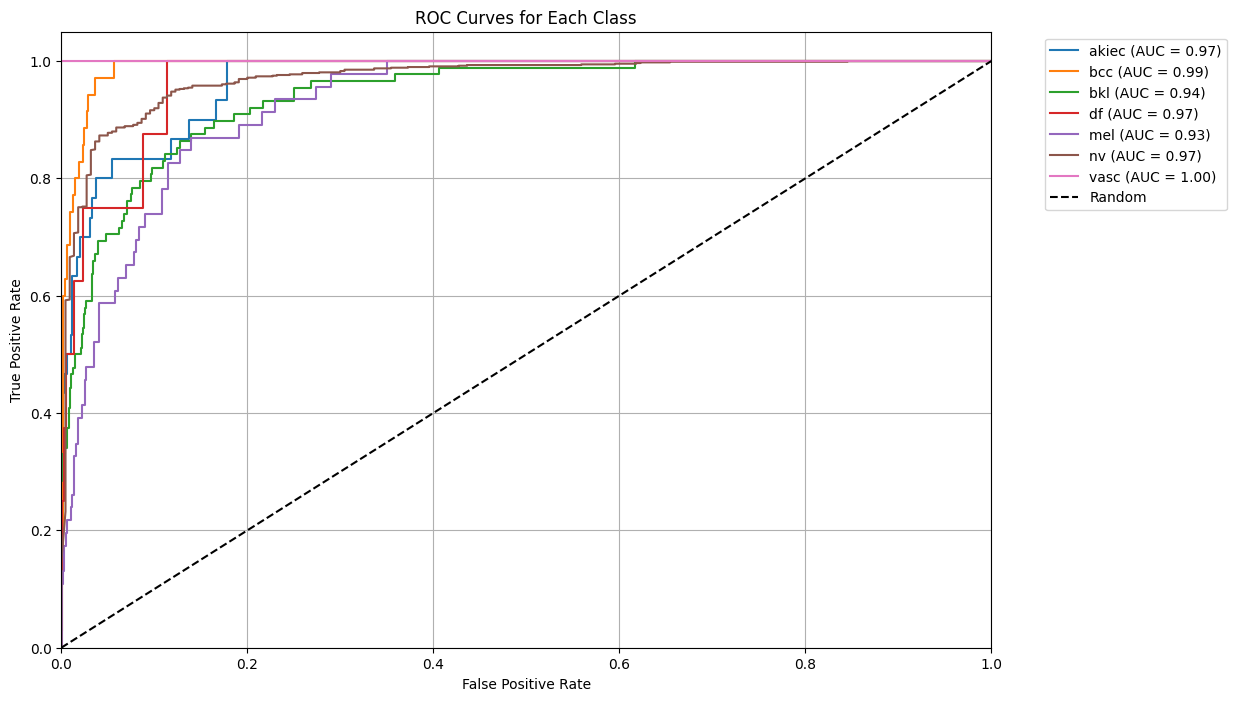

In [23]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves.png', bbox_inches='tight', dpi=300)
plt.close()

In [24]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


Normalized confusion matrix
[[0.46666667 0.13333333 0.1        0.         0.13333333 0.16666667
  0.        ]
 [0.02857143 0.74285714 0.17142857 0.         0.         0.05714286
  0.        ]
 [0.03409091 0.02272727 0.5        0.01136364 0.13636364 0.29545455
  0.        ]
 [0.125      0.125      0.125      0.125      0.         0.5
  0.        ]
 [0.02173913 0.04347826 0.13043478 0.         0.39130435 0.41304348
  0.        ]
 [0.0011325  0.00339751 0.00906002 0.         0.00906002 0.97734994
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


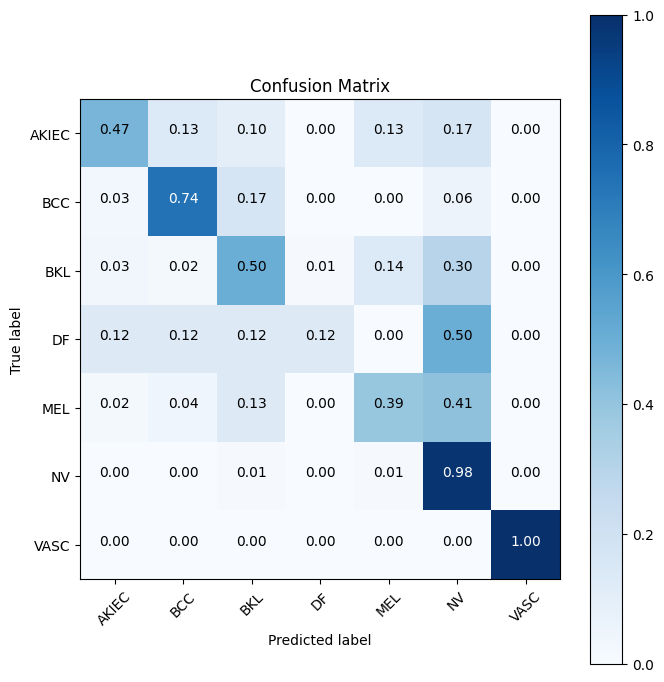

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [26]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.979148,0.980961,0.938350,0.992747,0.952856,0.931097,1.0,0.967880
f1,0.549020,0.712329,0.564103,0.200000,0.409091,0.957825,1.0,0.887579
false_discovery_rate,0.333333,0.315789,0.352941,0.500000,0.571429,0.060936,0.0,0.112421
false_negative_rate,0.533333,0.257143,0.500000,0.875000,0.608696,0.022650,0.0,0.112421
false_positive_rate,0.006524,0.011236,0.023645,0.000913,0.022706,0.254545,0.0,0.018737
negative_predictive_value,0.985213,0.991549,0.957488,0.993642,0.973610,0.891304,1.0,0.981263
positive_predictive_value,0.666667,0.684211,0.647059,0.500000,0.428571,0.939064,1.0,0.887579
precision,0.666667,0.684211,0.647059,0.500000,0.428571,0.939064,1.0,0.887579
recall,0.466667,0.742857,0.500000,0.125000,0.391304,0.977350,1.0,0.887579
sensitivity,0.466667,0.742857,0.500000,0.125000,0.391304,0.977350,1.0,0.887579


# Best Model Based on Validation Loss

In [27]:
tl_model.load_weights('val_loss_epoch.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [28]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - categorical_accuracy: 0.7664 - f1_score: 0.7681 - loss: 1.5886 - precision: 0.7723 - recall: 0.7641 - top_2_accuracy: 0.9034 - top_3_accuracy: 0.9579
val_loss: 0.8602636456489563
val_cat_acc: 0.8788222074508667
val_top_2_acc: 0.9558323621749878
val_top_3_acc: 0.9830124378204346
val_precision: 0.8831760287284851
val_recall: 0.8777791857719421
val_f1_score 0.8804399371147156


In [29]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [30]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - categorical_accuracy: 0.7852 - f1_score: 0.7835 - loss: 1.4237 - precision: 0.7888 - recall: 0.7784 - top_2_accuracy: 0.9135 - top_3_accuracy: 0.9574
test_loss: 0.7886835336685181
test_cat_acc: 0.8912057876586914
test_top_2_acc: 0.9573889374732971
test_top_3_acc: 0.9773345589637756
test_precision: 0.898529052734375
test_recall: 0.8923611044883728
test_f1_score 0.8954045176506042


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step

AUC Scores per class:
akiec: 0.964
bcc: 0.990
bkl: 0.932
df: 0.972
mel: 0.925
nv: 0.971
vasc: 1.000


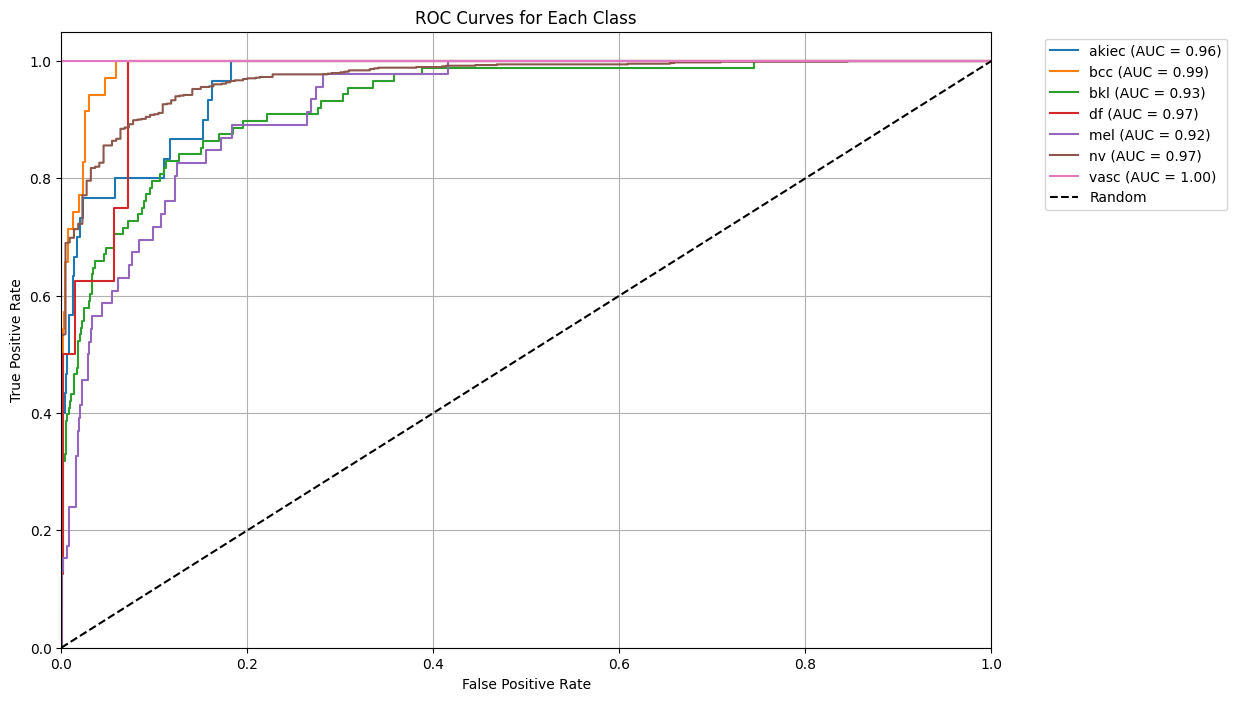

In [31]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves_valloss.png', bbox_inches='tight', dpi=300)
plt.close()

In [32]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


Normalized confusion matrix
[[0.43333333 0.1        0.06666667 0.         0.23333333 0.16666667
  0.        ]
 [0.05714286 0.74285714 0.14285714 0.02857143 0.         0.02857143
  0.        ]
 [0.02272727 0.02272727 0.54545455 0.01136364 0.15909091 0.23863636
  0.        ]
 [0.125      0.         0.125      0.25       0.         0.5
  0.        ]
 [0.02173913 0.04347826 0.08695652 0.         0.5        0.34782609
  0.        ]
 [0.0011325  0.00679502 0.01019253 0.         0.01019253 0.97168743
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


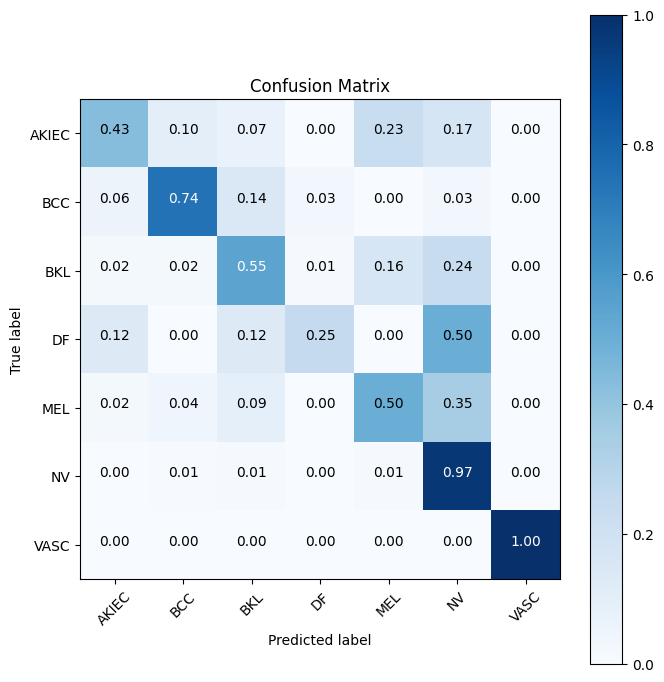

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix_valloss.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [34]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.978241,0.980054,0.944696,0.992747,0.951949,0.934723,1.0,0.968916
f1,0.520000,0.702703,0.611465,0.333333,0.464646,0.959732,1.0,0.891206
false_discovery_rate,0.350000,0.333333,0.304348,0.500000,0.566038,0.051934,0.0,0.108794
false_negative_rate,0.566667,0.257143,0.454545,0.750000,0.500000,0.028313,0.0,0.108794
false_positive_rate,0.006524,0.012172,0.020690,0.001826,0.028382,0.213636,0.0,0.018132
negative_predictive_value,0.984303,0.991541,0.961315,0.994540,0.978095,0.873737,1.0,0.981868
positive_predictive_value,0.650000,0.666667,0.695652,0.500000,0.433962,0.948066,1.0,0.891206
precision,0.650000,0.666667,0.695652,0.500000,0.433962,0.948066,1.0,0.891206
recall,0.433333,0.742857,0.545455,0.250000,0.500000,0.971687,1.0,0.891206
sensitivity,0.433333,0.742857,0.545455,0.250000,0.500000,0.971687,1.0,0.891206
